In [7]:
import numpy as np
import matplotlib_inline 
import matplotlib.pyplot as plt
import pandas as pd
import os 
import math
import pathlib
from pathlib import Path
import sys

In [8]:
#Importing the weekly sales data set 
data_path = Path(r"C:\Users\Matt\Desktop\Pharma Project\salesweekly.csv")
df = pd.read_csv(data_path)

In [9]:
df

datum  M01AB   M01AE  N02BA    N02BE  N05B  N05C        R03    R06
0      1/5/2014  14.00  11.670  21.30  185.950  41.0   0.0  32.000000   7.00
1     1/12/2014  29.33  12.680  37.90  190.700  88.0   5.0  21.000000   7.20
2     1/19/2014  30.67  26.340  45.90  218.400  80.0   8.0  29.000000  12.00
3     1/26/2014  34.00  32.370  31.50  179.600  80.0   8.0  23.000000  10.00
4      2/2/2014  31.02  23.350  20.70  159.880  84.0  12.0  29.000000  12.00
..          ...    ...     ...    ...      ...   ...   ...        ...    ...
297   9/15/2019  35.51  30.977  19.65  178.375  67.2   5.0  30.000000  30.50
298   9/22/2019  46.84  25.396  24.40  248.250  31.2   3.0  26.000000  21.00
299   9/29/2019  34.01  22.498  26.60  336.700  61.2   1.0  40.416667  23.10
300   10/6/2019  38.70  32.502  19.25  249.450  69.0   5.0  30.000000  12.13
301  10/13/2019   7.67   6.237   3.50   95.100  26.0   2.0  12.000000   1.00

[302 rows x 9 columns]

In [10]:
#Formatting the date column for time-series analysis 
df['datum'] = pd.to_datetime(df['datum'])
#df['Date'] = pd.to_datetime(df['datum'])
df.set_index('datum', inplace = True)


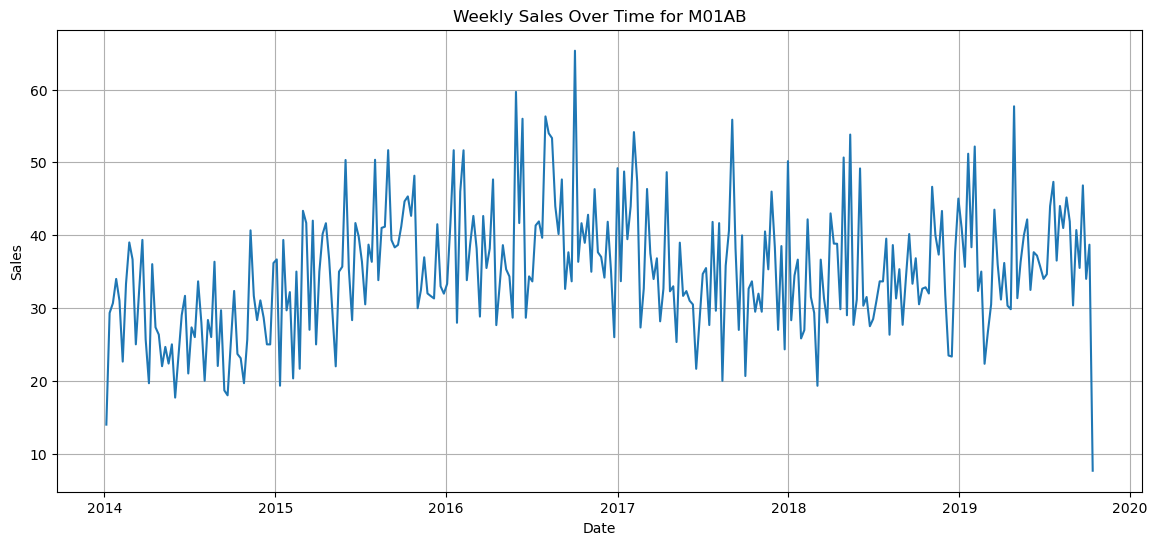

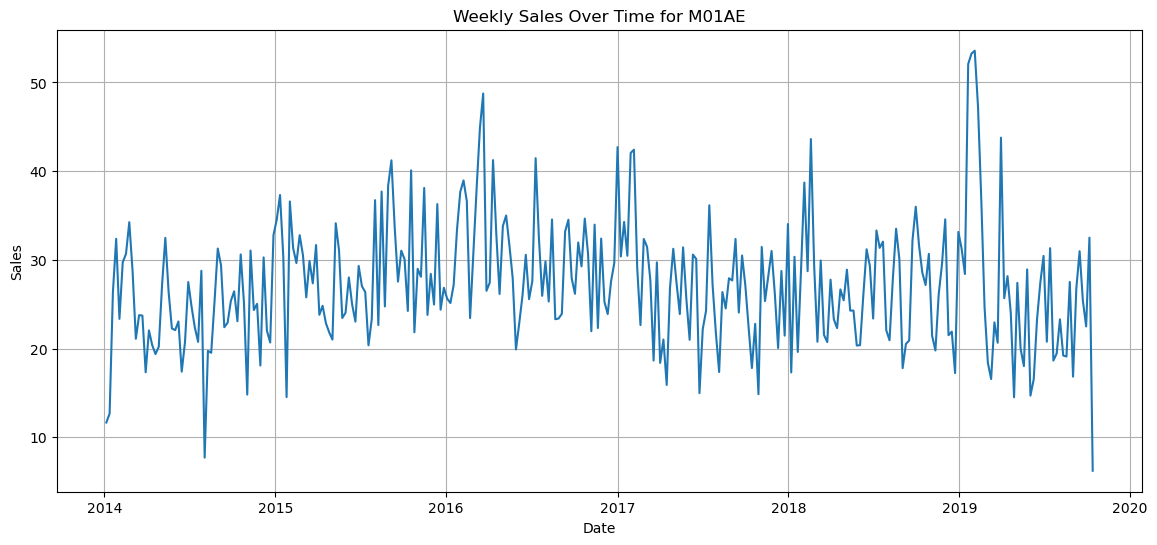

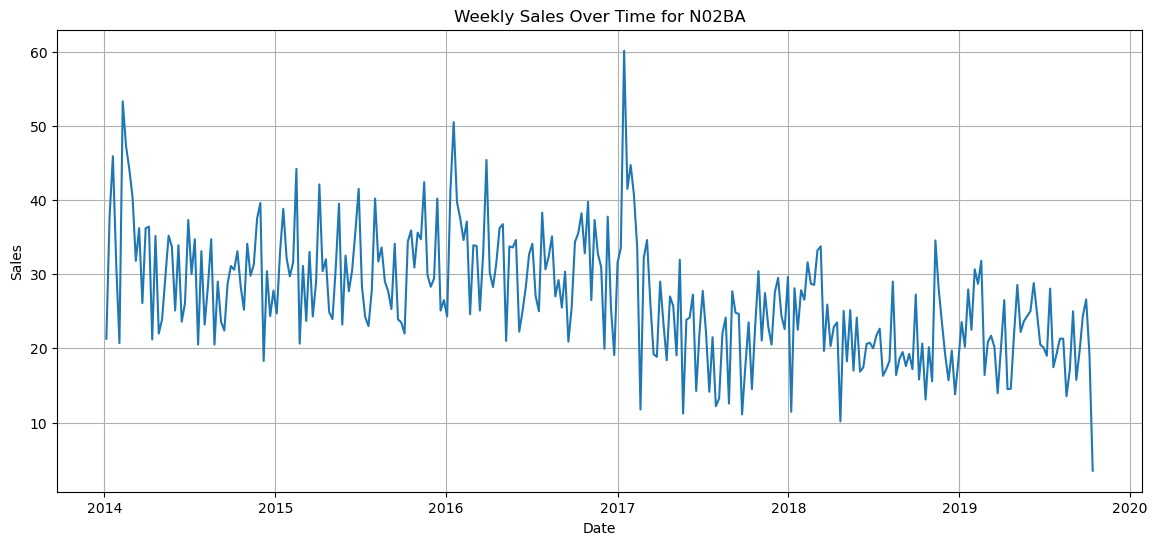

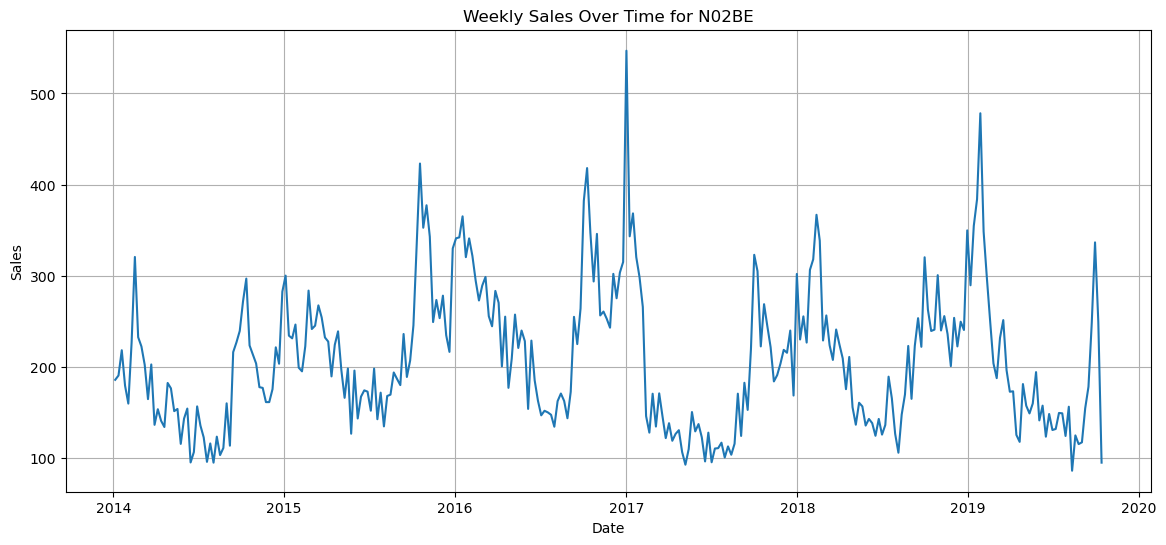

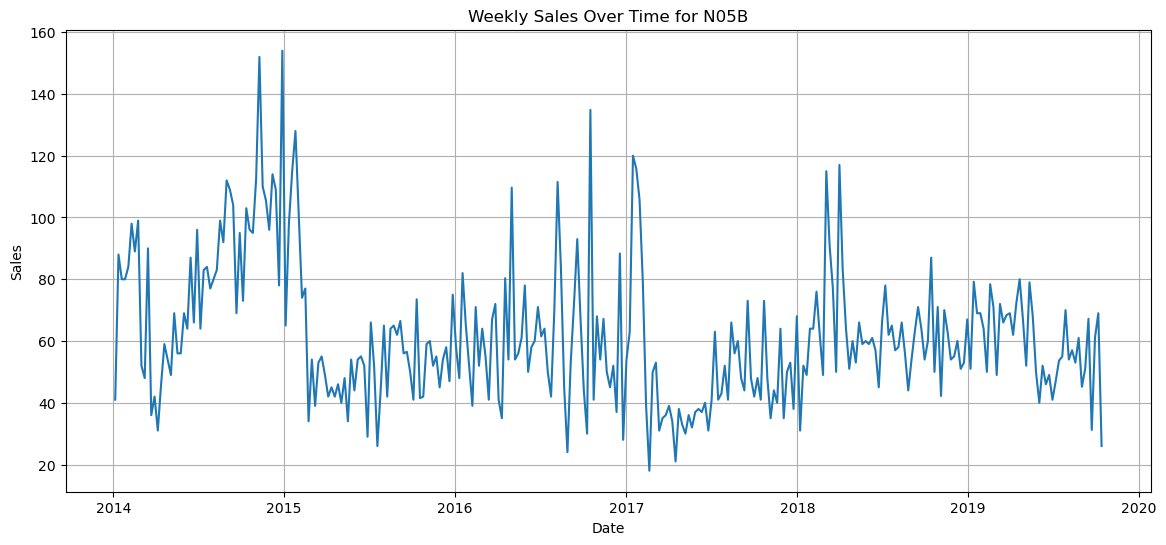

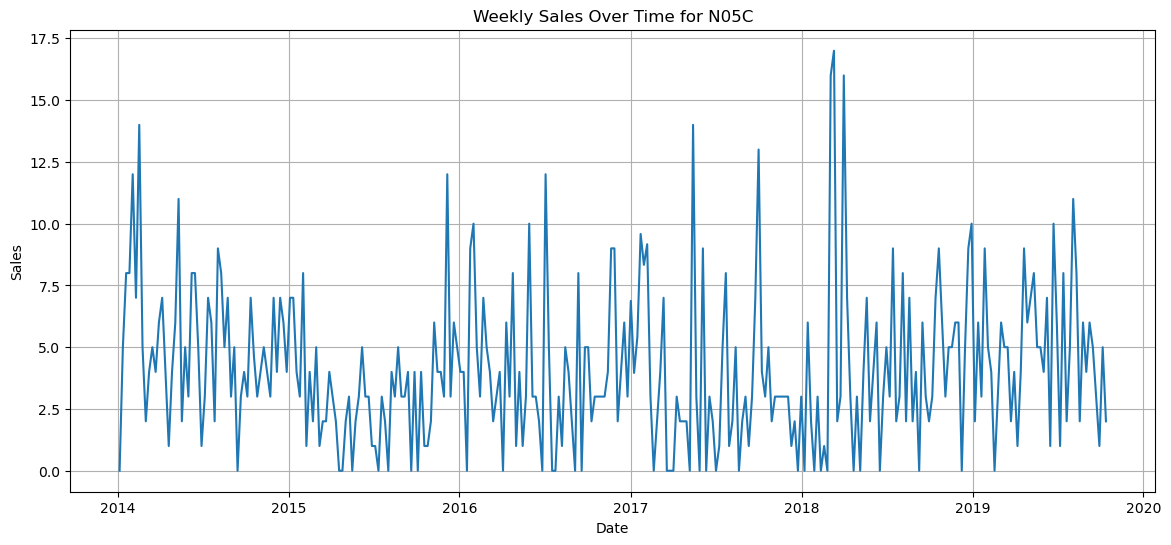

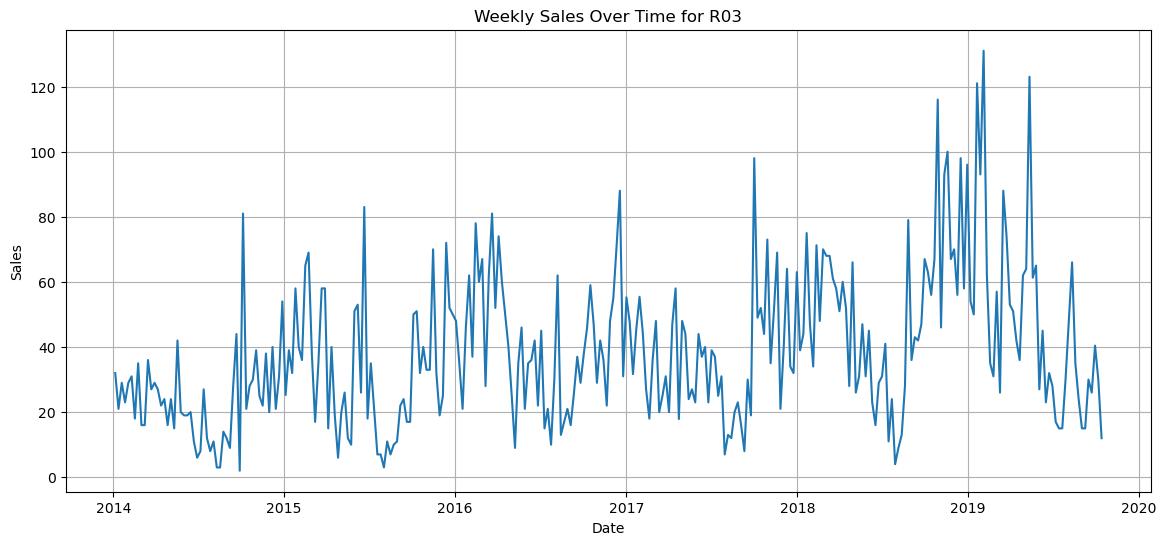

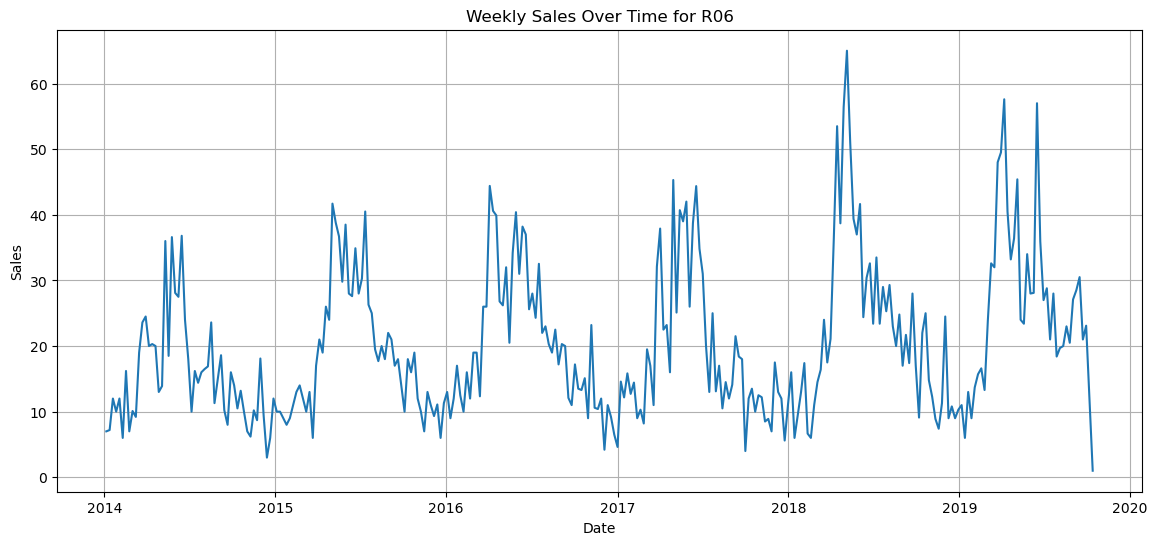

In [11]:
#Plotting the raw data set for each drug in spreadsheet
for column in df.columns:
    fig, ax = plt.subplots(figsize=(14, 6))
    ax.plot(df.index, df[column])
    ax.set_title(f"Weekly Sales Over Time for {column}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    ax.grid(True)
    plt.show()

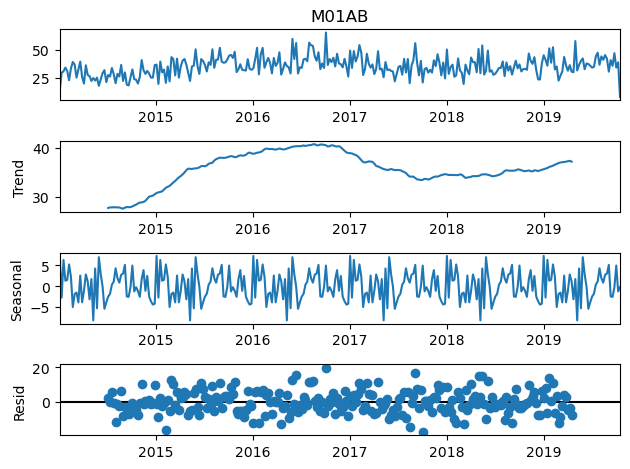

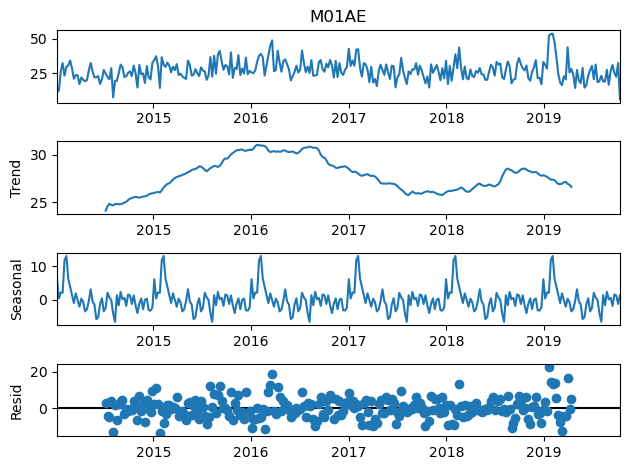

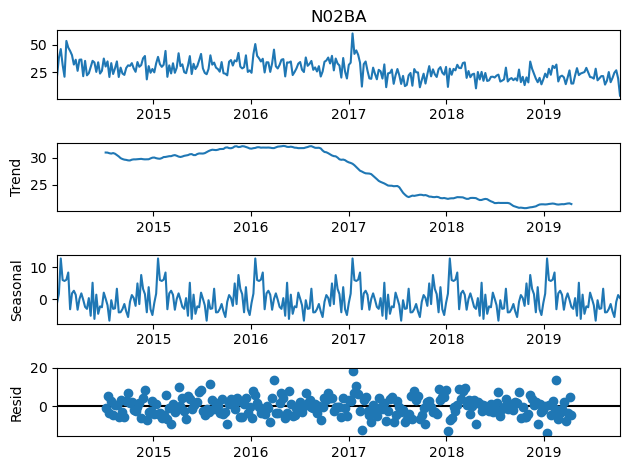

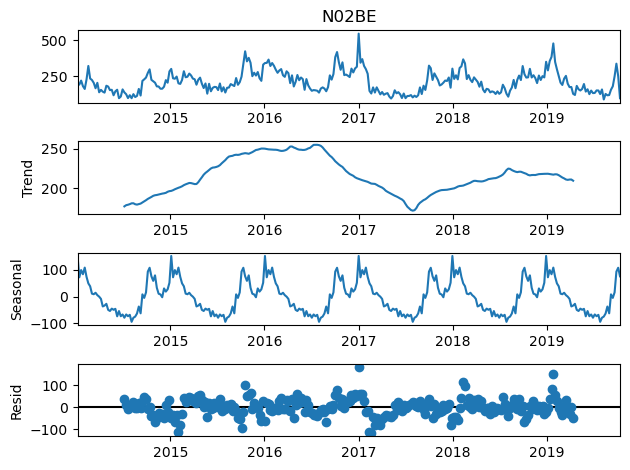

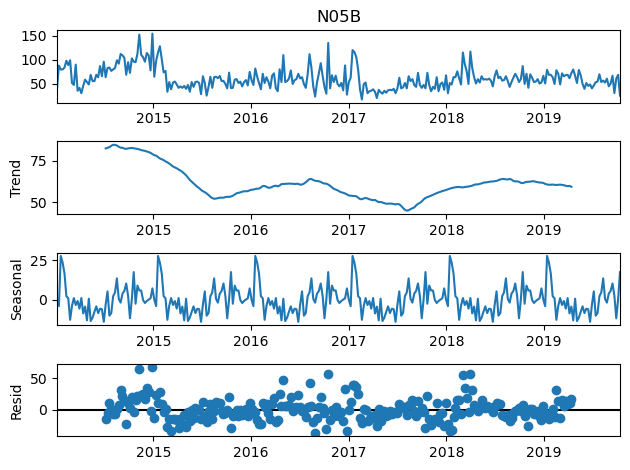

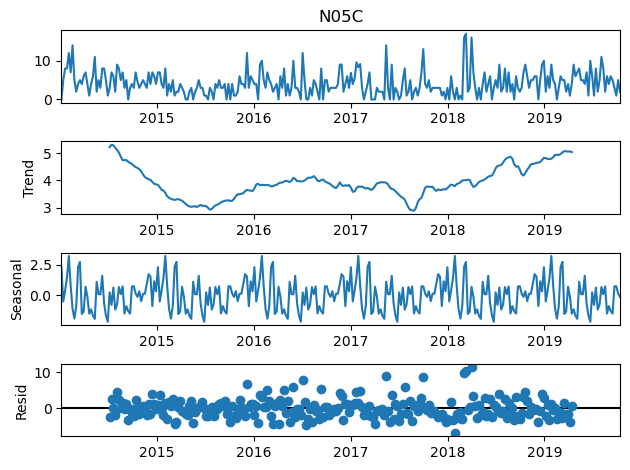

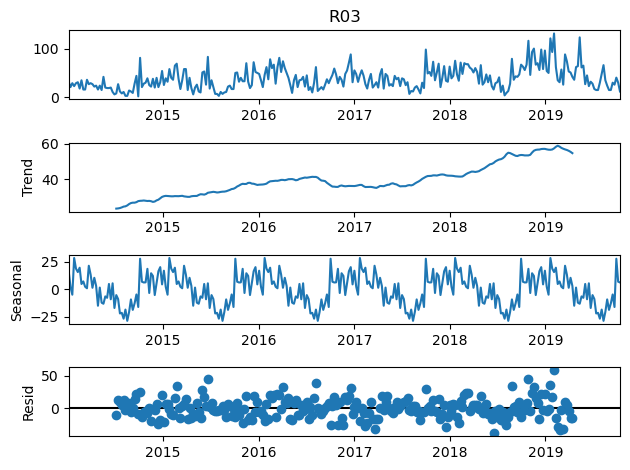

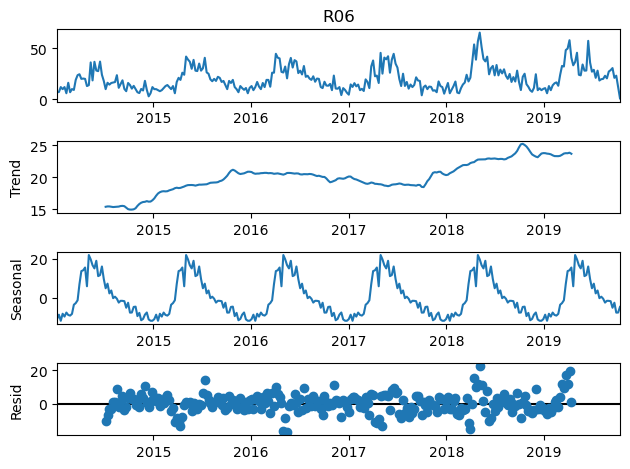

In [12]:
#DECOMPOSITION
#In this stage, we will decompose the data into several components for analysis 
#We decompose this into the trend, seasonality, and residual components. 
#This will allow us to more easily forecast trends in the data set

#We will use the statsmodels.tsa.decompose package to do this: 
from statsmodels.tsa.seasonal import seasonal_decompose
for col in df.columns:
    #For weekly data, we use period = 52
    result = seasonal_decompose(df[col], model = 'additive', period=52)
    result.plot()


In [13]:
#We note nonlinear trends for M01AB, M01AE, and N02BE
#We note there are strong downwards trends for N02BA and N05B 
#We note there are strong upwards trends for R03,N05C, and R06 

In [14]:
#STATIONARITY 
#We now check for stationarity in our data. We check that properties such as mean, variance, and autocorrelation are constant over time
#Many time series analysis methods require stationarity.
#We will test each using the Augmented Dickey-Fuller test

from statsmodels.tsa.stattools import adfuller


def perform_adf_test(series):
    result = adfuller(series)
    p_val = result[1]
    ADF_stat = result[0]
    #If the p-val is less than or approximatley the threshold (0.05), then we reject the null hypothesis
    print('p-value: %f' % p_val)
    #If the ADF Stat is lower than our crit values, we can reject the null hypothesis and conclude stationarity
    print('ADF Statistic: %f' % ADF_stat)
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    
for col in df.columns:
    #print(col)
    perform_adf_test(df[col])
    
    

p-value: 0.005235
ADF Statistic: -3.628724
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
p-value: 0.000000
ADF Statistic: -8.739383
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
p-value: 0.420122
ADF Statistic: -1.721399
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572
p-value: 0.000334
ADF Statistic: -4.370604
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
p-value: 0.005784
ADF Statistic: -3.598815
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
p-value: 0.000000
ADF Statistic: -15.000535
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572
p-value: 0.010372
ADF Statistic: -3.417632
Critical Values:
	1%: -3.453
	5%: -2.871
	10%: -2.572
p-value: 0.000020
ADF Statistic: -5.028058
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


In [15]:
#We note that stationarity exists for M01AB, M01AE, N02BE, N05C, N05B,R03, and R06
#We note the null hypothesis is true for N02BA.This will require further processing. 

In [16]:
#DIFFERENTIATION TO ACHIEVE STATIONARITY 
# We now work to achieve stationarity on N02BA 
# To accomplish this, we apply differencing to the series. This helps to stabalize the mean over time

#We will use the .diff() operation to accomplish this: 

df['N02BA_diff'] = df['N02BA'].diff()
#The first row will have NaN. Applying .dropna()
df = df.dropna()
#let us check whether our new series demonstrates stationarity: 

perform_adf_test(df['N02BA_diff'])

p-value: 0.000000
ADF Statistic: -9.202408
Critical Values:
	1%: -3.453
	5%: -2.872
	10%: -2.572


In [17]:
#we note that our new series demonstrates stationarity, as the p-val is lower than our threshold

In [30]:
#MODELING 
#Now that we have stationarity, we can choose a model to predict sales trends for each drug in our data 
#Additonally, by analyzing the trend decompositon, we determine that seasonality exists in the data sets
#We will therefore apply models that incorporate aspects of seasonality

#Firstly, we will utilize the SARIMA model

#This model contains an autoregressive part, the differencing order, and the moving average order as parameters
#denoted as (p,d,q)

#Additionally, there are parameters such as the order of seasonal differencing, the order of the seasonal autoregressive model, 
#the order of the seasonal moving average model, and the number of periods each season
#denoted as (P,D,Q,s)

# For simplicity, we will perfrom a grid search to test each combination of parameters. 

#To do so, we will utilize the pmdarima library

import pmdarima as pm 

import pmdarima as pm 
models = {}
period = 52
for index in range(0,len(df.columns)):
# the auto_arima function generates the best SARIMA model to the time series
    item = df.columns[index]
    print('performing function on {}'.format(item))
    
    model = pm.auto_arima(df[item], 
                          seasonal = True,
                          m = period, 
                          d = 1, 
                          D = 1, 
                          start_p=0, 
                          start_q = 0, 
                          max_p=2, 
                          max_q=2, 
                          trace = True, 
                          error_action = 'ignore', 
                          suppress_warnings = True, 
                          stepwise = True)
    models[index] = model
    print('ARIMA{}x{}{} - AIC:{}'.format(model.order, model.seasonal_order, period, model.aic()))

performing function on M01AB
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=12.13 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=2054.888, Time=0.36 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1920.239, Time=2.62 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=5.14 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=1967.726, Time=0.36 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=1904.494, Time=6.16 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=33.34 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=18.25 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=inf, Time=4.82 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=1885.698, Time=7.73 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=1899.143, Time=3.69 sec
 ARIMA(2,1,0)(2,1,1)[52]             : AIC=inf, Time=35.97 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=23.24 sec
 ARIMA(2,1,1)(2,1,0)[52]             : AIC=1831.898, Time=14.62 sec
 ARIMA(2,1,1)(1,1,0

In [31]:
print('done')

done


0
M01AB
 ARIMA(0,1,1)(2,1,0)[52]          


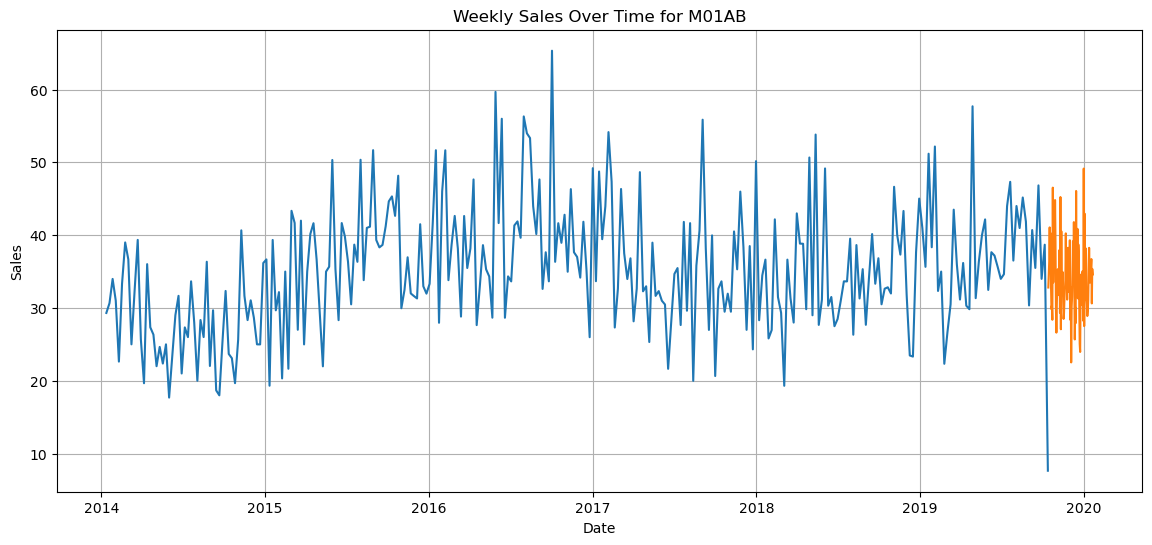

0
M01AE
 ARIMA(1,1,1)(2,1,0)[52] intercept


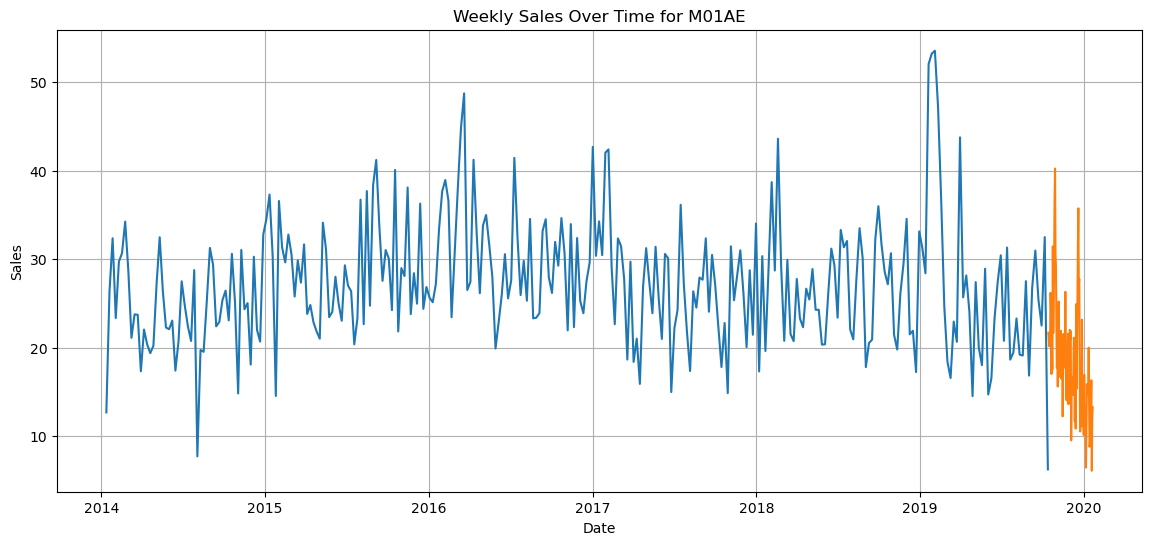

0
N02BA
 ARIMA(1,1,1)(2,1,0)[52]          


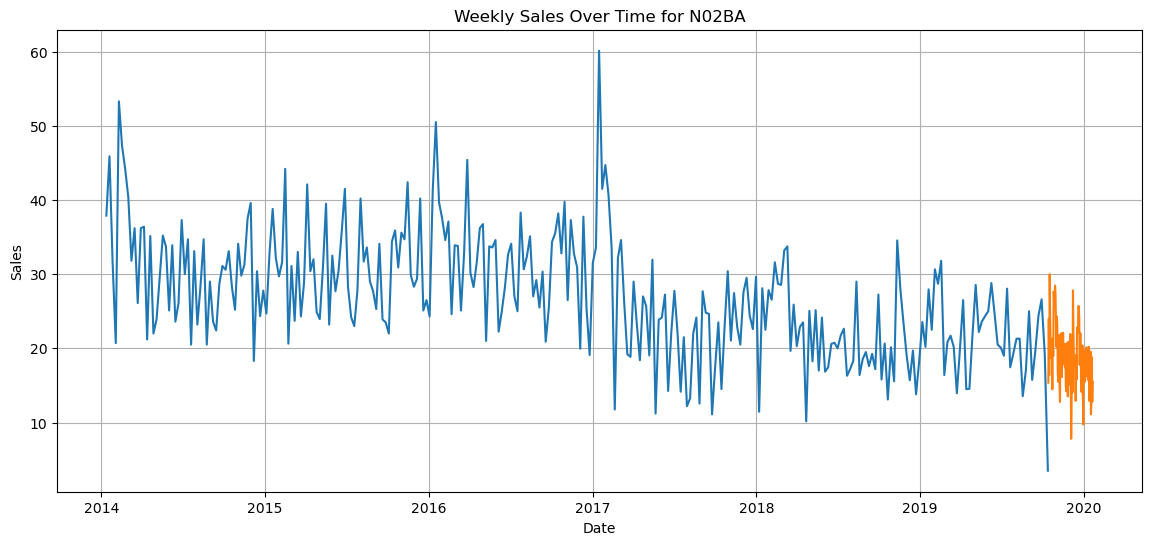

0
N02BE
 ARIMA(2,1,1)(2,1,0)[52]          


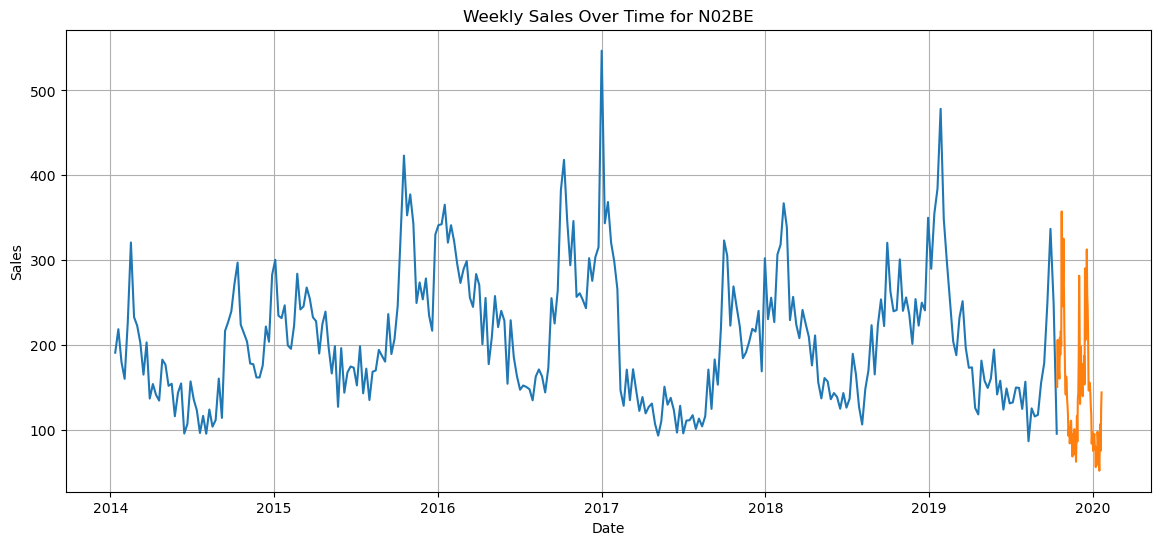

0
N05B
 ARIMA(0,1,1)(2,1,0)[52]          


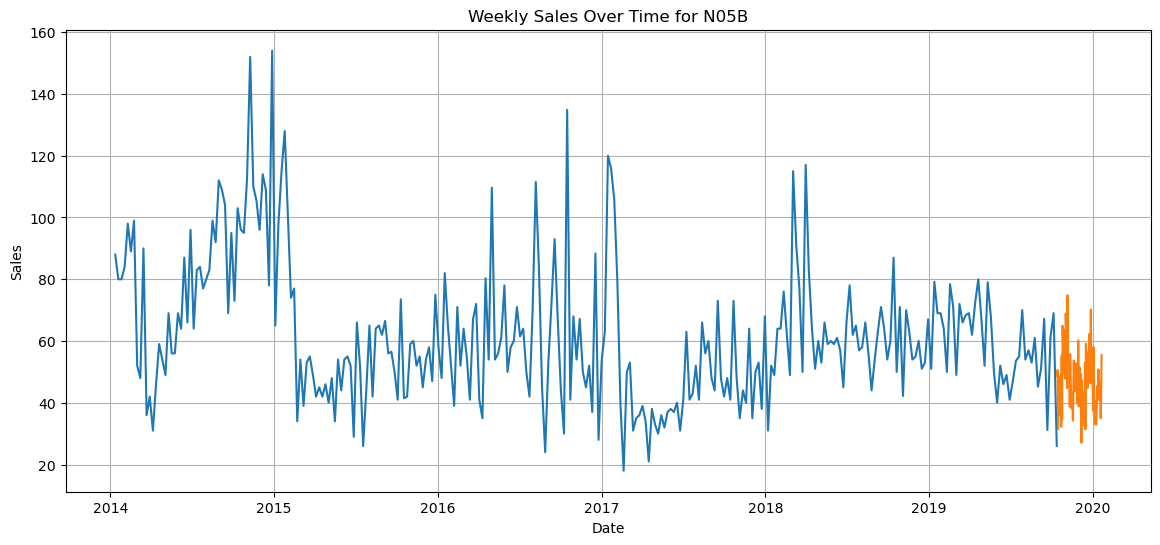

0
N05C
 ARIMA(0,1,1)(2,1,0)[52] intercept


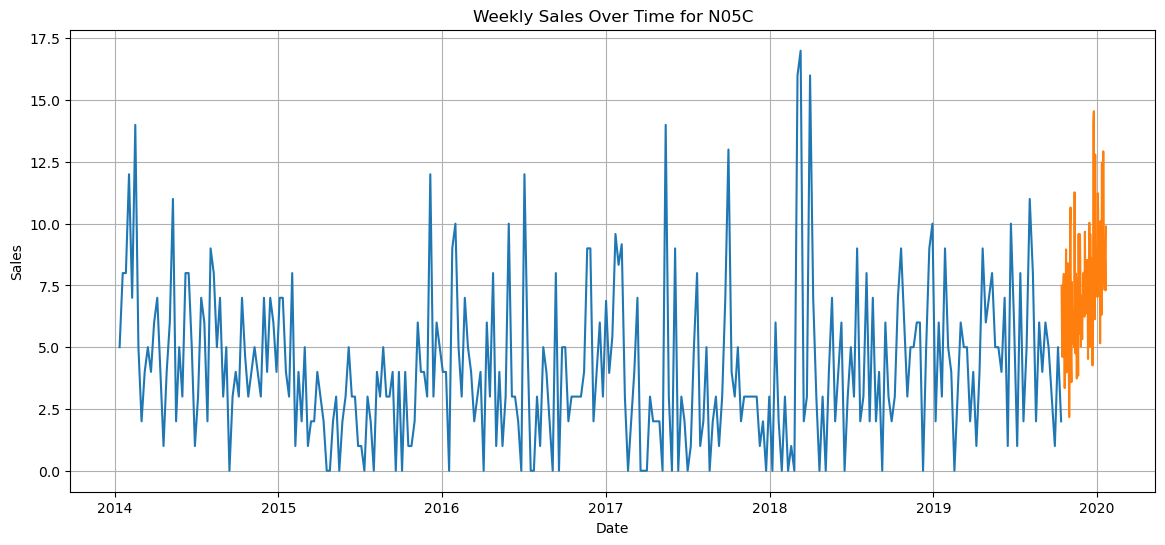

0
R03
 ARIMA(1,1,1)(2,1,0)[52]          


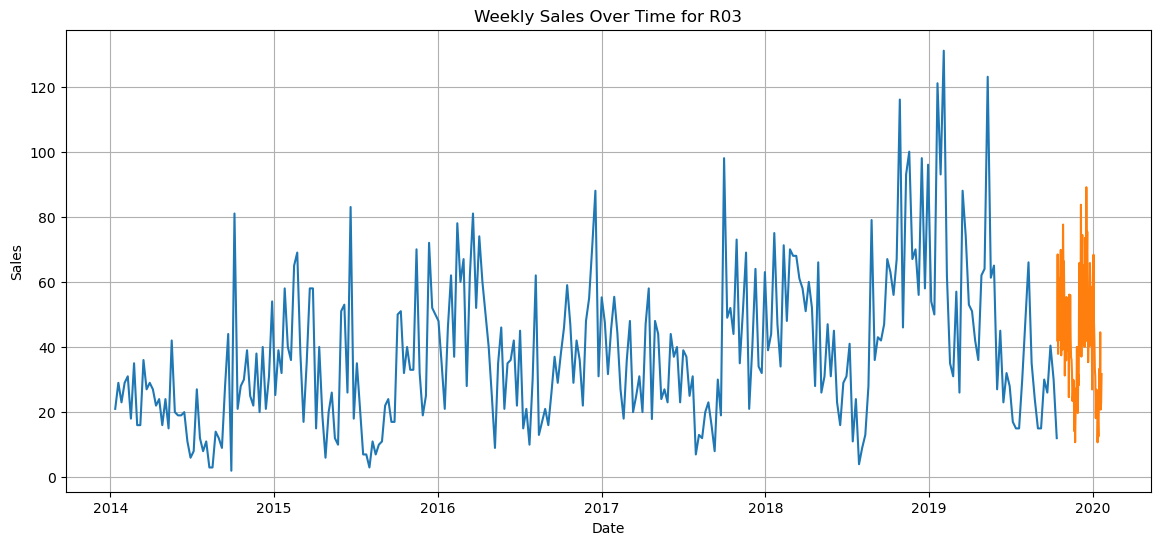

0
R06
 ARIMA(0,1,2)(2,1,0)[52]          


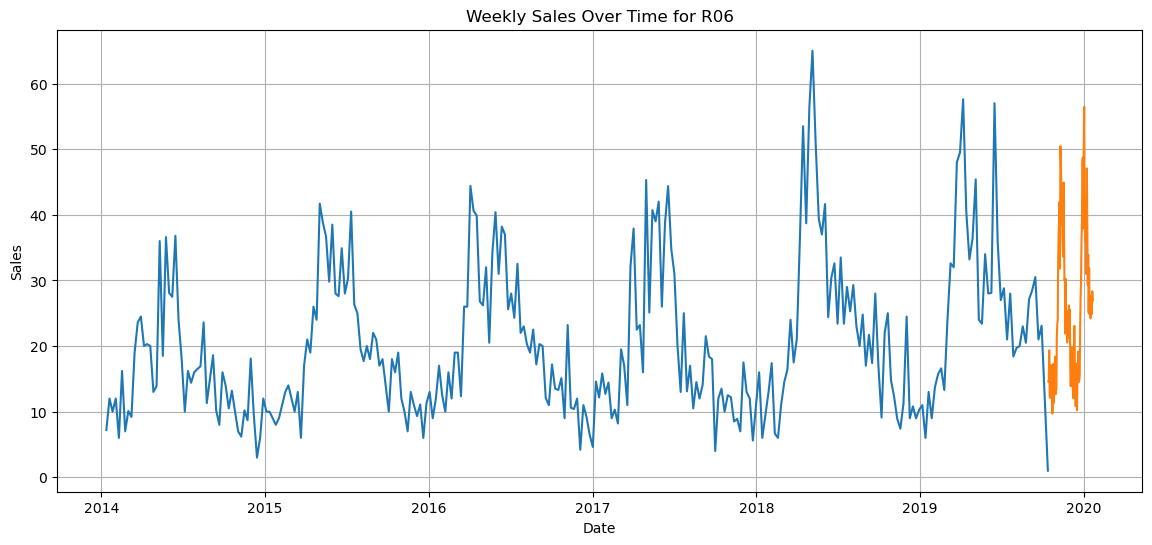

0
N02BA_diff
 ARIMA(2,1,0)(2,1,0)[52]          


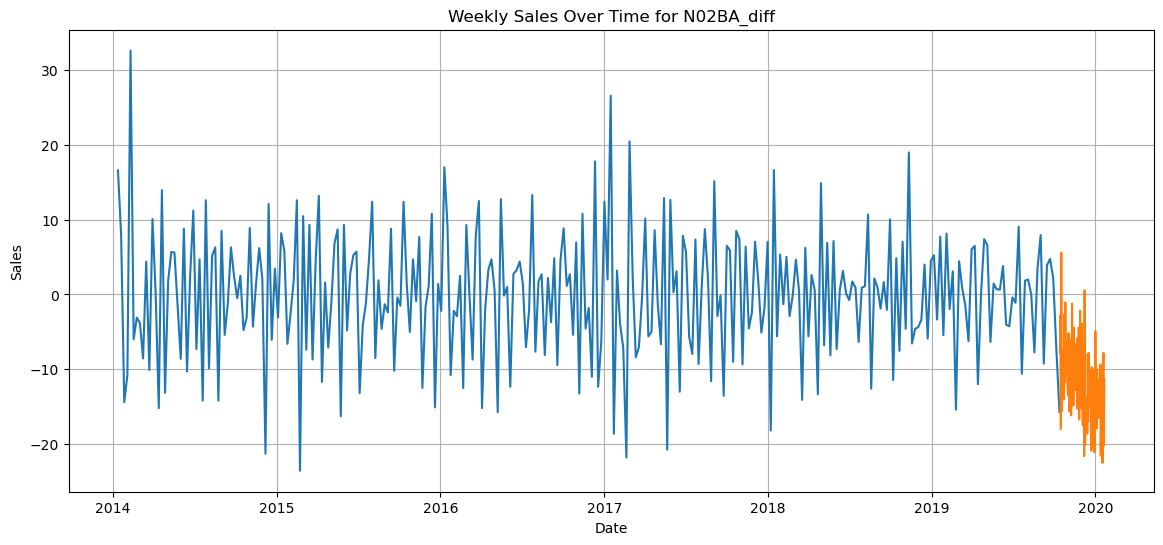

In [66]:
#FORECASTING
#We now have a list of models that are trained for each drug in our data set. 

#Let us predict the sales of our drugs for n periods using the model 
#We plot the original data set in blue 
#We plot the forecasted data set in orange
import warnings
warnings.filterwarnings('ignore')
n = 100
for i in range (0,len(models)):
    print(index)
    print(df.columns[i])
    print(models[i])
    forecasted_model = models[i].predict(n_periods= n)
    fig, ax = plt.subplots(figsize=(14, 6))
    plt.plot(df.index, df[df.columns[i]], label = "True Data")
    ax.set_title(f"Weekly Sales Over Time for {df.columns[i]}")
    ax.set_xlabel('Date')
    ax.set_ylabel('Sales')
    forecasted_dates= pd.date_range(start=df.index[-1], periods=n+1, closed='right')
    plt.plot(forecasted_dates, forecasted_model, label = "Forecasted Data")
    ax.grid(True)
    plt.show()
    
#The plots below forecast the sales of each drug for 100 periods using our SARIMA models

In [72]:
#MODEL ANALYSIS 
#We now wish to evaluate the performance of our models mathematically 

#To do this, we will use training train the model on a section of our data set 
#We will then compare it to the remaining data in our data set and see how accurate it is 

#To accomplish this, we will use metrics such as mean squared error, mean absolute error, and root mean squared error
from sklearn.metrics import mean_squared_error, mean_absolute_error

#This section splits our data set 
train_length = int(len(df)*.75)
forecast_length = int(len(df)-train_length)

training_data= df.iloc[:train_length]
forecast_data = df.iloc[train_length:]

#creating models based on data 
evaluation_models = {}
period = 52
for index in range(0,len(df.columns)):
# the auto_arima function generates the best SARIMA model to the time series
    item = df.columns[index]
    print('performing function on {}'.format(item))
    training_data= df[item][:train_length]
    test_data = df[item][train_length:]
    model = pm.auto_arima(training_data, 
                          seasonal = True,
                          m = period, 
                          d = 1, 
                          D = 1, 
                          start_p=0, 
                          start_q = 0, 
                          max_p=2, 
                          max_q=2, 
                          trace = True, 
                          error_action = 'ignore', 
                          suppress_warnings = True, 
                          stepwise = True)
    evaluation_models[item] = model
    
    forecast_data = model.predict(n_periods = len(test_data))
    mse = mean_squared_error(test_data, forecast_data)
    mae = mean_absolute_error(test_data, forecast_data)
    rmse = np.sqrt(mse)
    print('Evaluations for {}'.format(item))
    print('MSE:{}'.format(mse))
    print('MAE:{}'.format(mae))
    print('RMSE:{}'.format(rmse))
    
    print('ARIMA{}x{}{} - AIC:{}'.format(model.order, model.seasonal_order, period, model.aic()))

performing function on M01AB
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(1,1,1)[52]             : AIC=inf, Time=7.12 sec
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1420.398, Time=0.30 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1341.654, Time=2.15 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=7.90 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=1374.525, Time=0.29 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=1335.218, Time=5.12 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=22.76 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=12.61 sec
 ARIMA(0,1,0)(2,1,0)[52]             : AIC=inf, Time=3.72 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=1319.243, Time=7.02 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=1326.031, Time=2.86 sec
 ARIMA(2,1,0)(2,1,1)[52]             : AIC=inf, Time=31.06 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=17.92 sec
 ARIMA(2,1,1)(2,1,0)[52]             : AIC=1283.972, Time=14.50 sec
 ARIMA(2,1,1)(1,1,0)

Diagnostics for: M01AB
Diagnostics for: M01AE
Diagnostics for: N02BA
Diagnostics for: N02BE
Diagnostics for: N05B
Diagnostics for: N05C
Diagnostics for: R03
Diagnostics for: R06
Diagnostics for: N02BA_diff


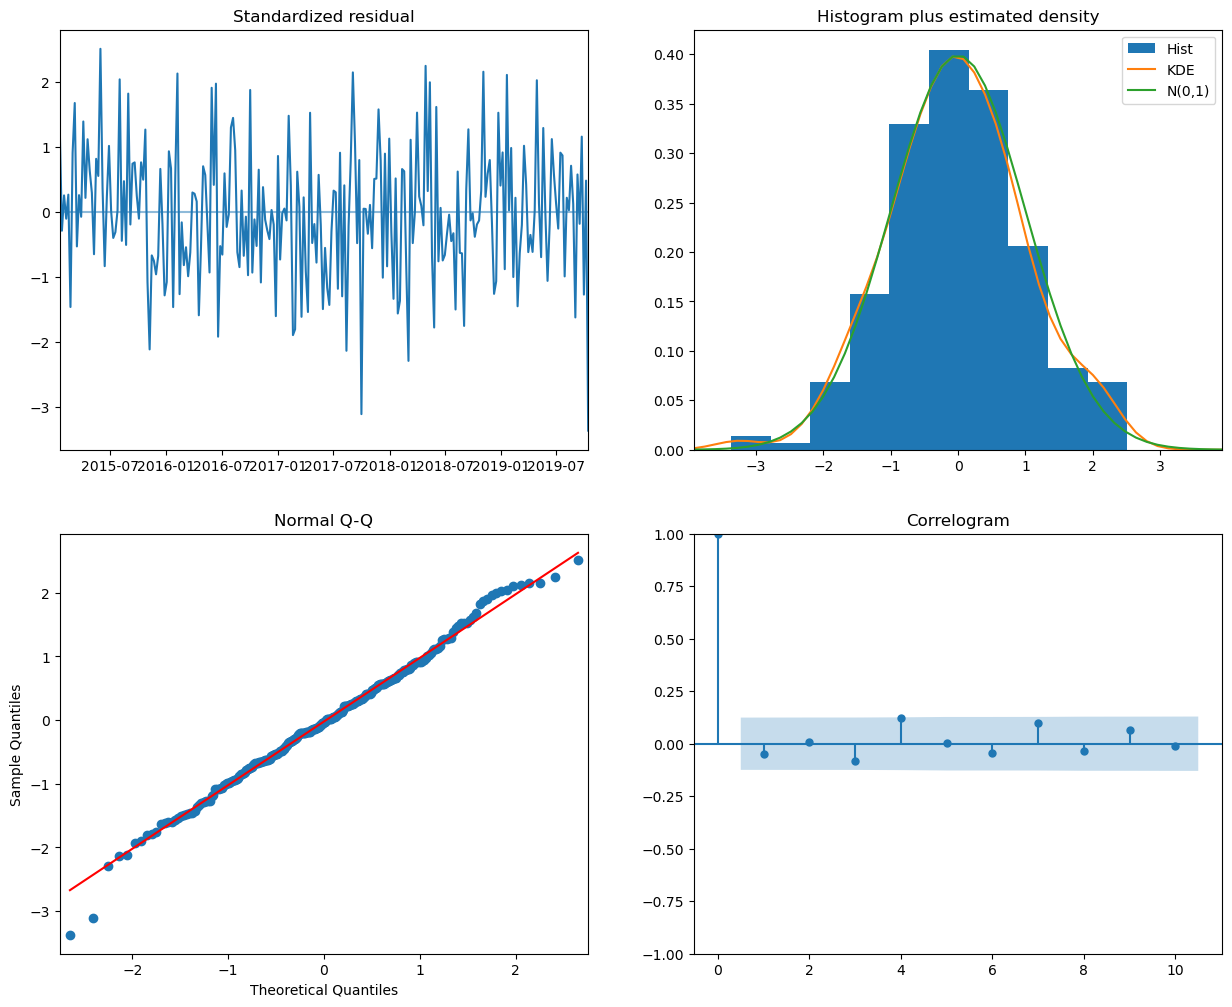

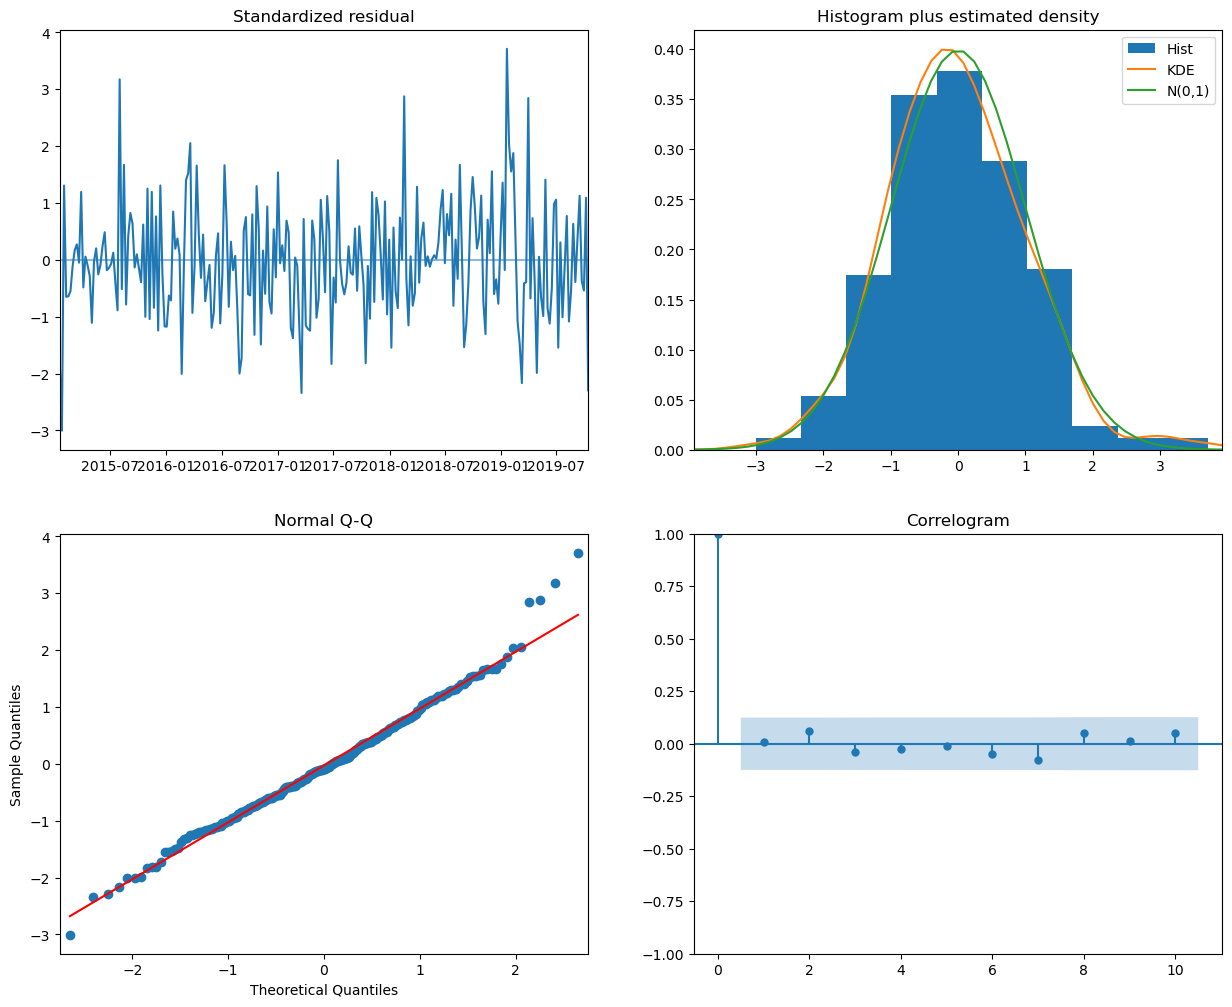

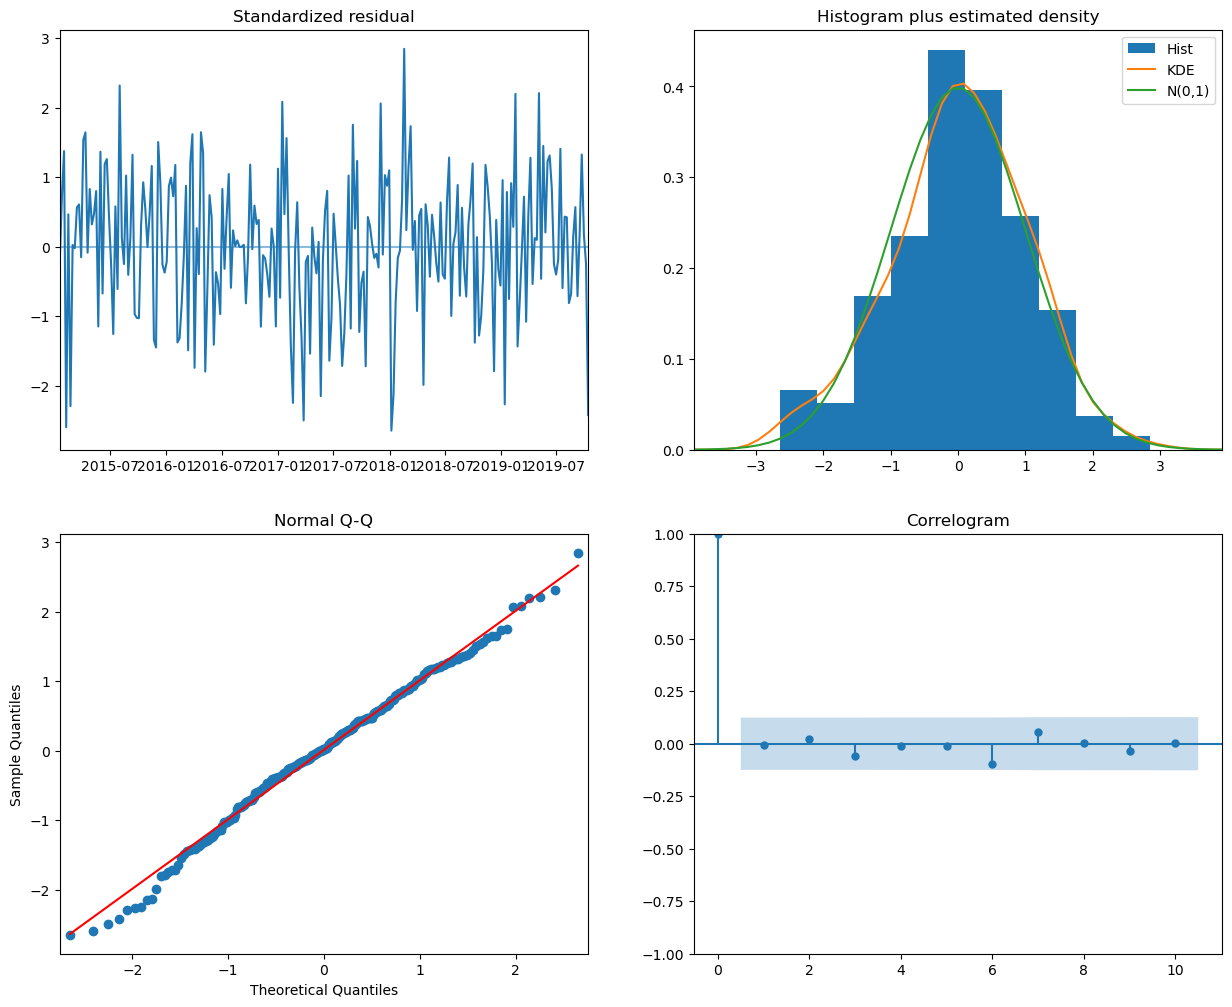

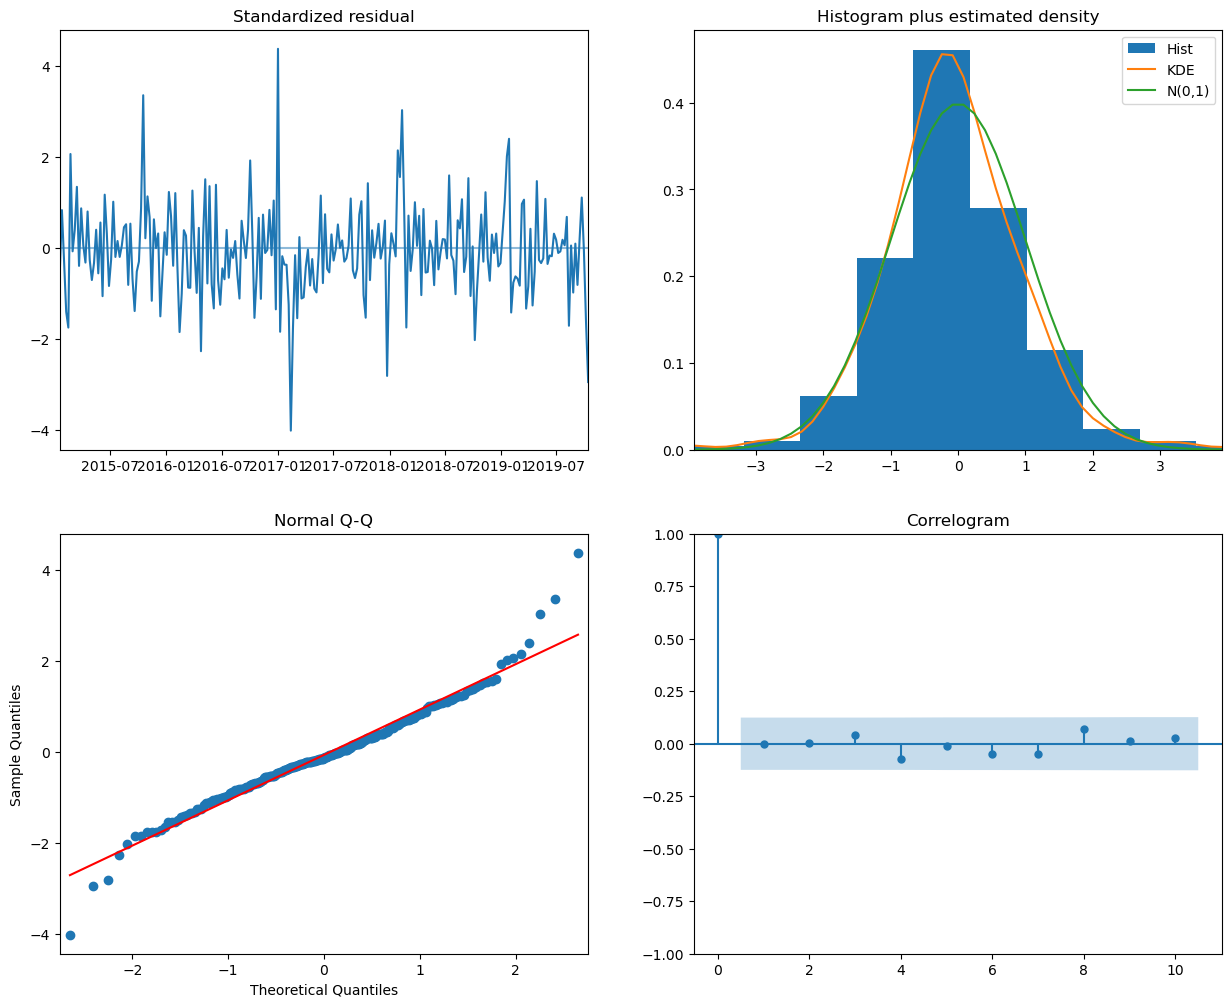

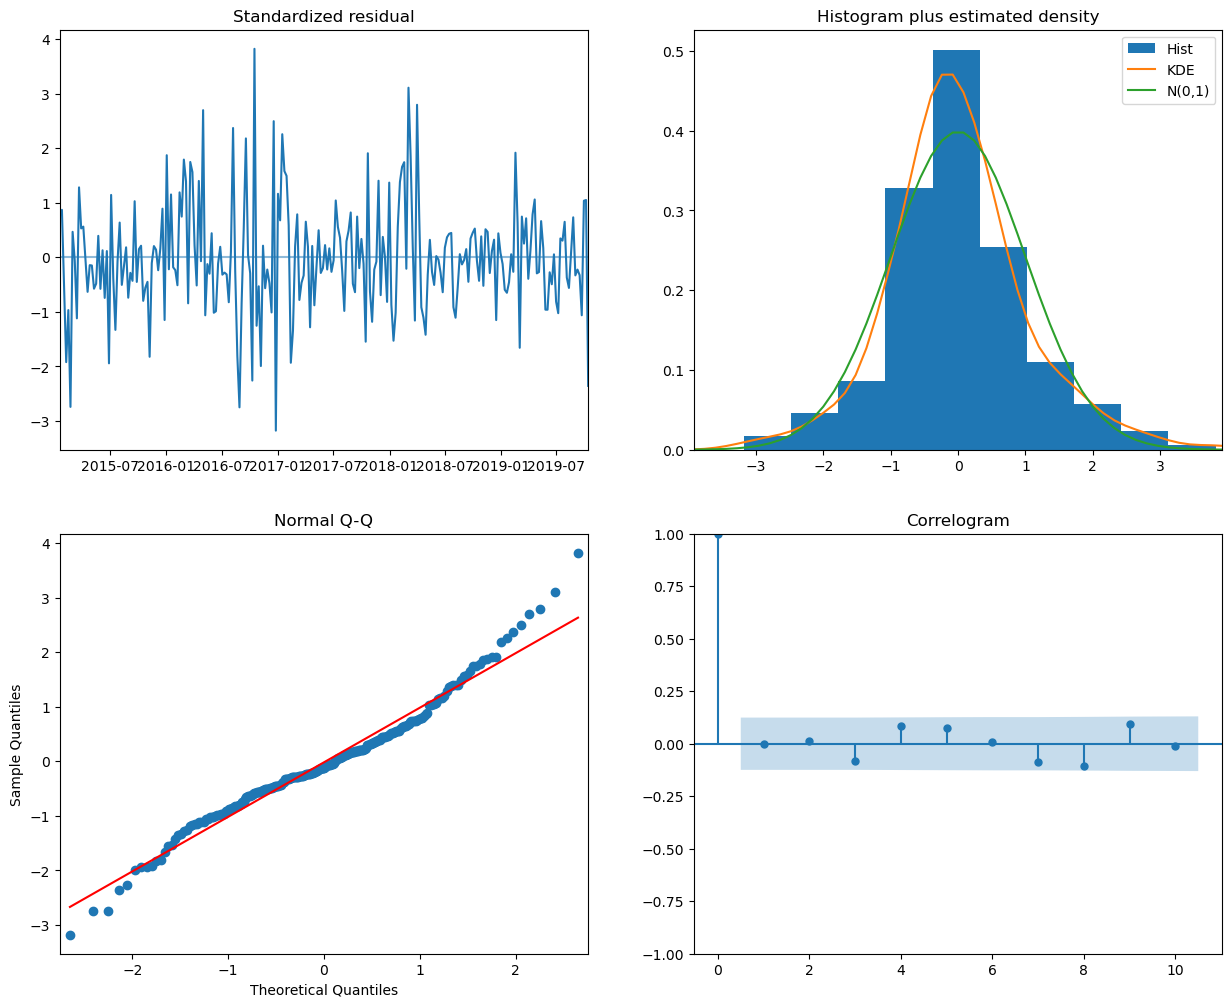

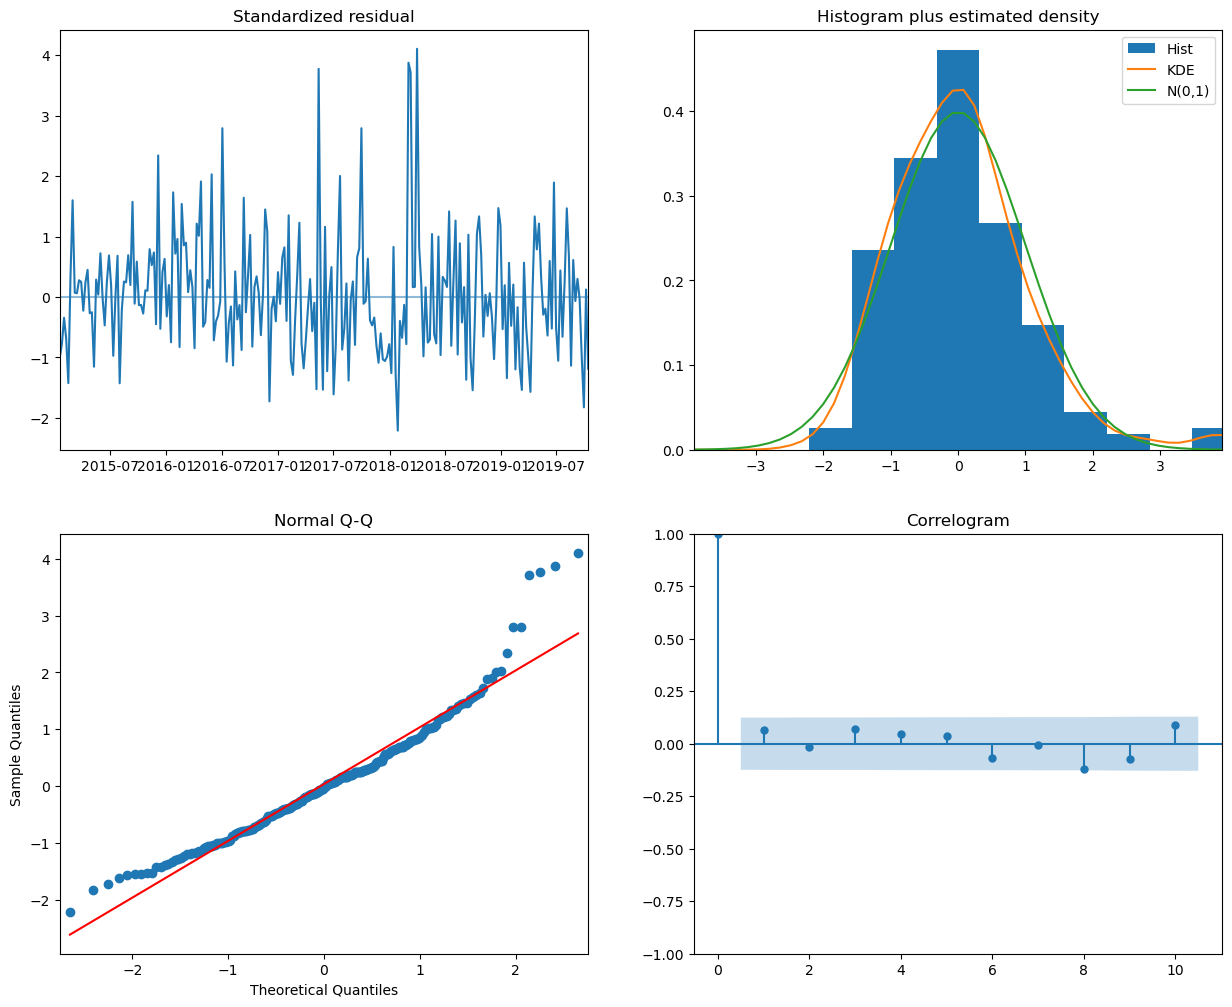

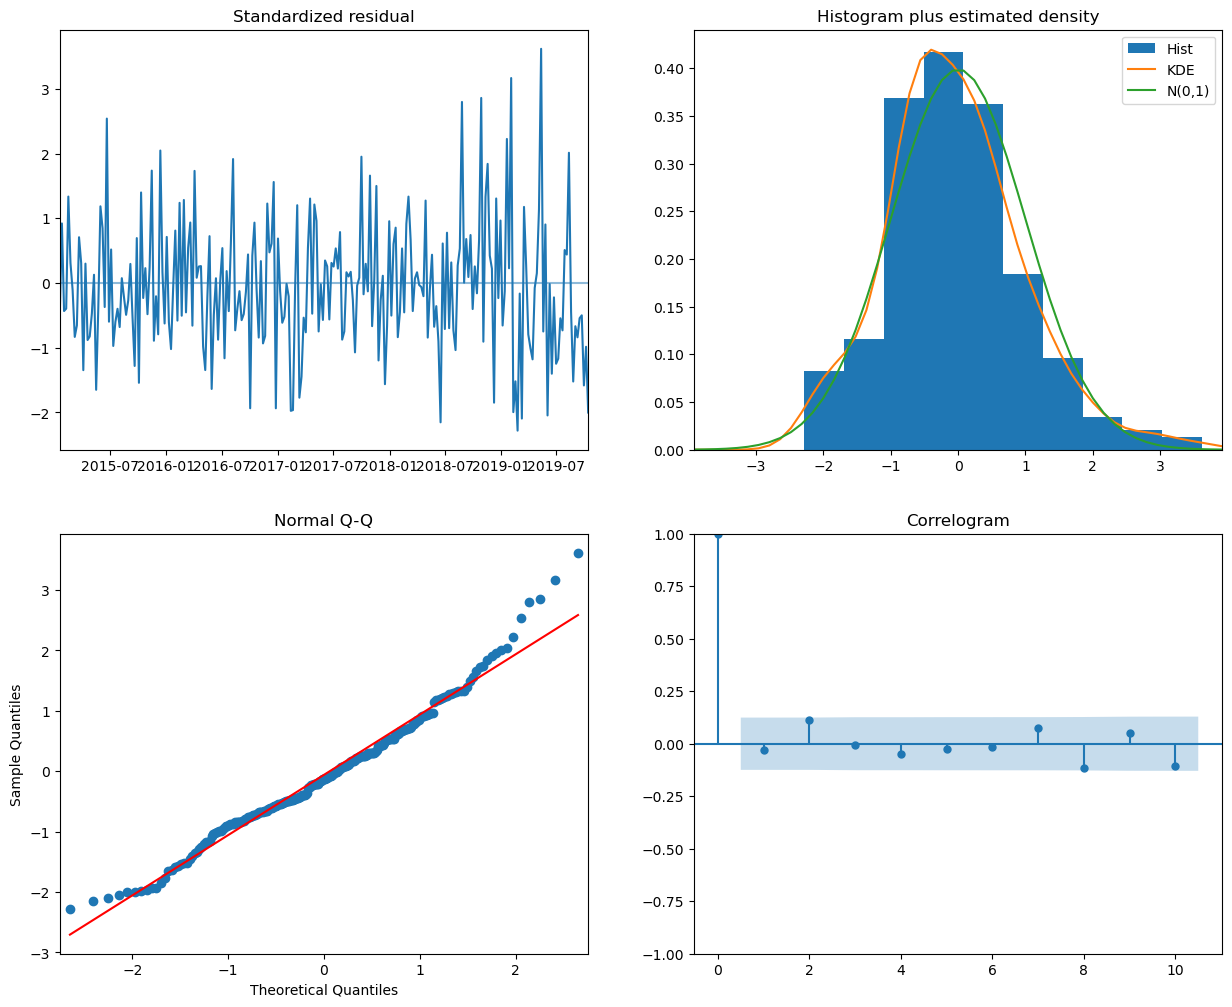

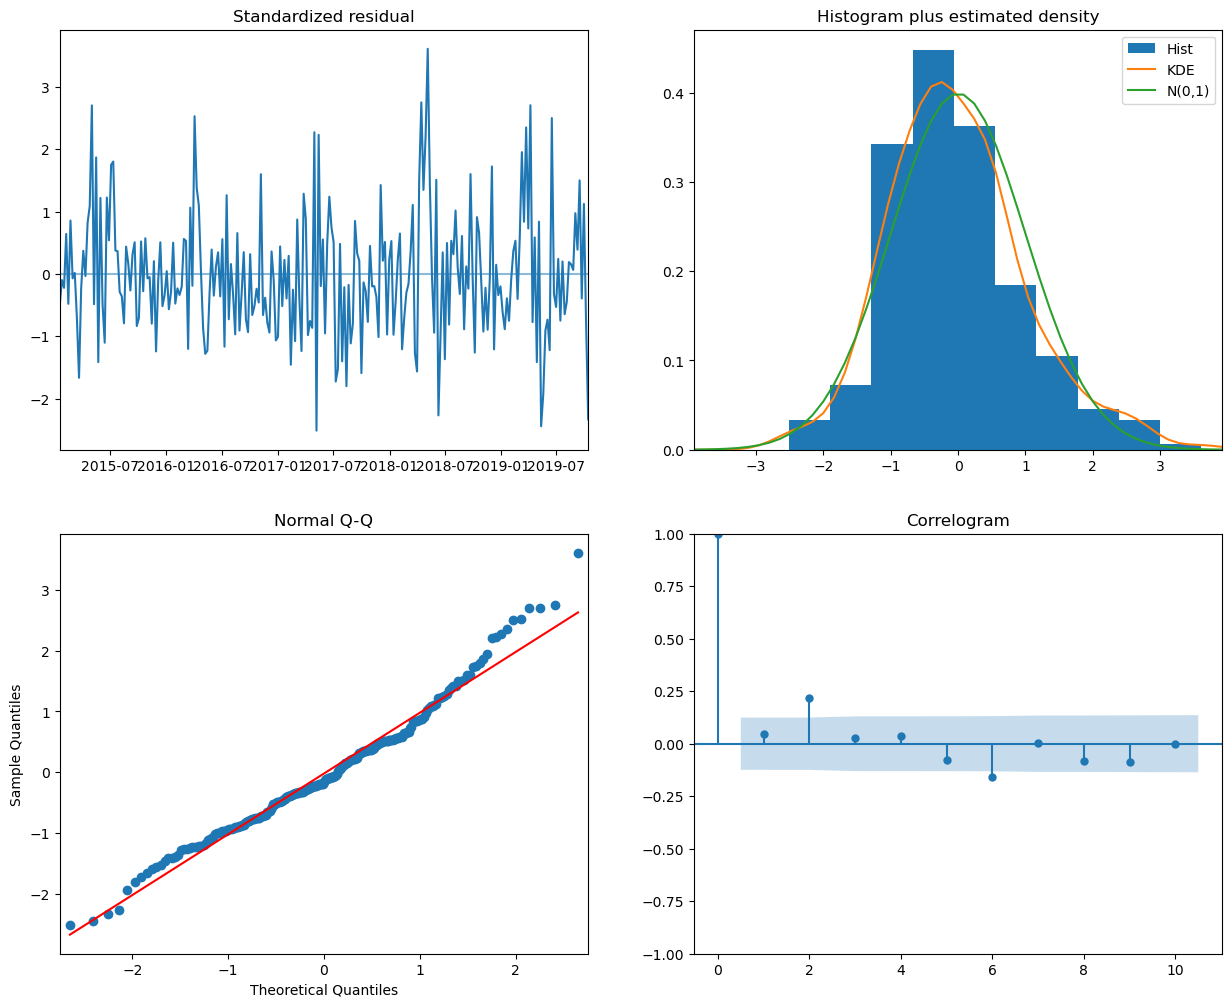

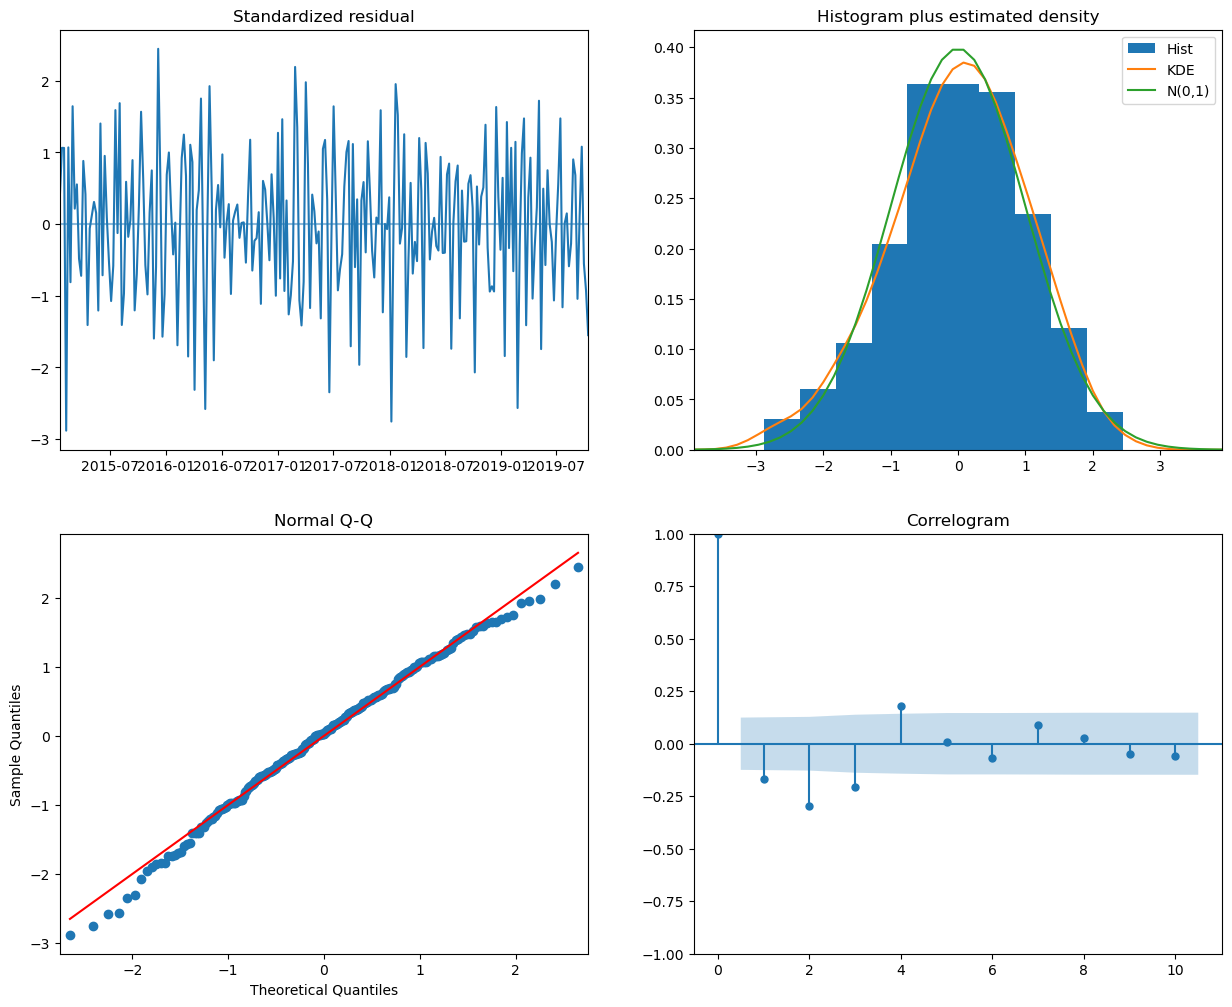

In [77]:
#Note that the lower the RMSE, MAE, and MSE are, the more accurate the model 

#We will now also plot the diagnostics of each model to better understand their utility: 

for index in models: 
    print('Diagnostics for: {}'.format(df.columns[index]))
    models[index].plot_diagnostics(figsize=(15,12))